# Reflect Pattern Example

## Overview

In this example, we’ll extend the previous Plan and Execute tutorial by introducing an additional **Reflect stage**.
This new stage allows the system to analyze the generated plan and execution results, detect potential issues, and fix recurring or systematic errors—ultimately increasing output quality.  

This pattern is particularly effective for increasing the overall output quality of an AI system. While **prompt engineering** can reduce mistakes, it does not always solve systematic or recurring errors—for example, repeated mistakes during plan creation. The Reflect pattern addresses this limitation by explicitly reasoning about possible failures and correcting them.

## What Is the Reflect Pattern?

The Reflect pattern is an agentic design approach where the system reviews its own response fixing the potential identified issues before continuing.

## Why Use the Reflect Pattern?

The Reflect pattern is useful when, after applying a test or evaluation strategy, you observe that many errors are caused by specific and recurring cases. These errors are often not random, but systematic, and they tend to reappear even when the system is generally working well.  
In these situations, simply changing or refining the prompt is not always optimal. While prompt quality must always be verified and improved first, testing may show that prompt modifications do not lead to a measurable increase in output quality for certain failure cases.  
When this happens, the Reflect pattern becomes a practical solution. Instead of relying only on prompt adjustments, the system explicitly analyzes its own outputs, identifies known error patterns, and applies corrective logic before producing the final result.

In other words:
- First, you should always validate and improve the prompt as much as possible.
- Then, if testing shows no significant quality gains for specific error cases, reflection can be introduced to handle those failures directly.

By combining testing, prompt verification, and reflection, the system can achieve higher reliability and better overall output quality

## What We'll Build

In this example, we’ll reuse the math expression solver from previous tutorials and enhance it with a reflection stage.  

The system will be composed of five stages:
1. **Intent Validation** - Validates user wants to compute an expression
2. **Expression Validation** - Validates expression syntax using a lexer
3. **Planning** - Creates a step-by-step execution plan
4. **Reflection** - Analyzes the generated plan to detect potential errors or inefficiencies and fixes them.
5. **Execution** - Executes the plan to compute the result



**NOTE:** Most of code is copied from previuos example. If you already followed it you can skip directly to **Reflect Prompt** definition

## Setup and Dependencies installation

Before we begin, we need to install the required libraries. Uncomment and run the cell below to install the dependencies.

In [1]:
# !pip install langchain-openai==1.1.0
# !pip install langchain==1.1.0
# !pip install langgraph==1.0.4
# !pip install python-dotenv==1.2.1

In [2]:
from langgraph.graph import StateGraph, MessagesState, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Literal, List, Optional, Annotated
import math
from dotenv import load_dotenv
from langchain_core.prompts import ChatPromptTemplate
from langchain.agents import create_agent
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage, SystemMessage
import os
import re
from IPython.display import Image, display

# Load environment variables
load_dotenv()

True

## Configure API Key

Set up the OpenAI API key. Make sure you have your API key in a `.env` file or set it directly.

In [3]:
# Set the OpenAI API key from environment variable
# Make sure you have OPENAI_API_KEY in your .env file or uncomment the line below
# os.environ['OPENAI_API_KEY'] = 'your-api-key-here'

api_key = os.getenv('OPENAI_API_KEY')
if not api_key:
    print("⚠️ Warning: OPENAI_API_KEY not found in environment variables")
else:
    print("✓ OpenAI API key loaded successfully")

✓ OpenAI API key loaded successfully


## Tool Definitions

**What are Tools?**
As specified in previous examples of these tutorial series, tools are functions that agents can invoke to perform specific tasks. In LangChain, tools are Python functions with:
- Clear docstrings describing their purpose
- Type-annotated parameters
- Structured return values

Our agents will have access to these tools and can call them when needed to answer user queries.

### Math Tools

We define now the tools that are used for basic math operation that could be used by the model to solve the expression.  

In [4]:
def add(a: float, b: float) -> dict:
    """Adds two numbers.

    Args:
        a (float): First number
        b (float): Second number

    Returns:
        dict: Computation status and result
    """
    print("  TOOL CALLED: add")
    print(f"   INPUT: a = {a}, b = {b}")

    try:
        result_value = a + b
        result = {"status": "success", "result": result_value}
        print(f"   OUTPUT: {result}")
        return result
    except Exception as e:
        result = {"status": "error", "error_message": str(e)}
        print(f"   OUTPUT: {result}")
        return result


def subtract(a: float, b: float) -> dict:
    """Subtracts one number from another.

    Args:
        a (float): Minuend
        b (float): Subtrahend

    Returns:
        dict: Computation status and result
    """
    print("  TOOL CALLED: subtract")
    print(f"   INPUT: a = {a}, b = {b}")

    try:
        result_value = a - b
        result = {"status": "success", "result": result_value}
        print(f"   OUTPUT: {result}")
        return result
    except Exception as e:
        result = {"status": "error", "error_message": str(e)}
        print(f"   OUTPUT: {result}")
        return result


def multiply(a: float, b: float) -> dict:
    """Multiplies two numbers.

    Args:
        a (float): First number
        b (float): Second number

    Returns:
        dict: Computation status and result
    """
    print("  TOOL CALLED: multiply")
    print(f"   INPUT: a = {a}, b = {b}")

    try:
        result_value = a * b
        result = {"status": "success", "result": result_value}
        print(f"   OUTPUT: {result}")
        return result
    except Exception as e:
        result = {"status": "error", "error_message": str(e)}
        print(f"   OUTPUT: {result}")
        return result


def divide(a: float, b: float) -> dict:
    """Divides one number by another.

    Args:
        a (float): Dividend
        b (float): Divisor

    Returns:
        dict: Computation status and result
    """
    print("  TOOL CALLED: divide")
    print(f"   INPUT: a = {a}, b = {b}")

    if b == 0:
        result = {"status": "error", "error_message": "Cannot divide by zero."}
        print(f"   OUTPUT: {result}")
        return result

    try:
        result_value = a / b
        result = {"status": "success", "result": result_value}
        print(f"   OUTPUT: {result}")
        return result
    except Exception as e:
        result = {"status": "error", "error_message": str(e)}
        print(f"   OUTPUT: {result}")
        return result


def power(a: float, b: float) -> dict:
    """Raises a number to a given power.

    Args:
        a (float): Base
        b (float): Exponent

    Returns:
        dict: Computation status and result
    """
    print("🔧 TOOL CALLED: power")
    print(f"   INPUT: a = {a}, b = {b}")

    try:
        result_value = a ** b
        result = {"status": "success", "result": result_value}
        print(f"   OUTPUT: {result}")
        return result
    except Exception as e:
        result = {"status": "error", "error_message": str(e)}
        print(f"   OUTPUT: {result}")
        return result


def factorial(n: int) -> dict:
    """Calculates the factorial of a non-negative integer.

    Args:
        n (int): Non-negative integer

    Returns:
        dict: Computation status and result
    """
    print("  TOOL CALLED: factorial")
    print(f"   INPUT: n = {n}")

    if n < 0:
        result = {"status": "error", "error_message": "Factorial is not defined for negative numbers."}
        print(f"   OUTPUT: {result}")
        return result

    if n > 170:
        result = {"status": "error", "error_message": "Number too large. Factorial computation limited to n <= 170."}
        print(f"   OUTPUT: {result}")
        return result

    try:
        factorial_result = 1
        for i in range(2, n + 1):
            factorial_result *= i

        result = {"status": "success", "result": factorial_result}
        print(f"   OUTPUT: {result}")
        return result
    except Exception as e:
        result = {"status": "error", "error_message": str(e)}
        print(f"   OUTPUT: {result}")
        return result


## Expression Validation Tool using a Lexer

In [5]:
class Tokenizer:
    """
    Stateful string tokenizer that returns one token at a time including whitespaces.
    """

    def __init__(self, text: str, separators: List[str]):
        self.text = text
        # Sort separators longest-first to support multi-char operators
        self.separators = sorted(separators, key=len, reverse=True)
        self.pos = 0
        self.length = len(text)

    def nextToken(self) -> Optional[str]:
        """
        Returns the next token or None if input is exhausted.
        """
        if self.pos >= self.length:
            return None

        # Check if current position matches a separator
        for sep in self.separators:
            if self.text.startswith(sep, self.pos):
                self.pos += len(sep)
                return sep

        # Otherwise, read until a separator is found
        start = self.pos
        while self.pos < self.length:
            if any(self.text.startswith(sep, self.pos) for sep in self.separators):
                break
            self.pos += 1

        return self.text[start:self.pos]

    # Optional iterator support
    def __iter__(self):
        return self

    def __next__(self):
        token = self.nextToken()
        if token is None:
            raise StopIteration
        return token

In [6]:
def strip_whitespaces(str_tokens: List[str])-> bool:
    str_tokens_strip = []
    
    for str_token in str_tokens:
        str_tokens_strip += [str_token.strip()]

    return str_tokens_strip

In [7]:
def validate_expression(expression: str) -> dict:
    """
    Check if math expression syntax is valid and is computable by the system.
    Args:
        expression (str): Expression to validate

    Returns:
        bool: Validation result
        error: In case is not valid this field contain the reason of the failure
    """

    SEPARATORS = ["+", "-", "*", '/']
    tokenizer = Tokenizer(
        expression,
        separators=SEPARATORS
    )

    str_tokens = []
    for token in tokenizer:
        str_tokens += [token]

    str_tokens = strip_whitespaces(str_tokens)
    print(str_tokens)

    FLOAT_NUMBER_REGEX = r"^[0-9]+(\.[0-9]+)?$"
    NUMBER_WITH_EXPONENT_REGEX = r"^([0-9]+(\.[0-9]+)?)\^([0-9]+(\.[0-9]+)?)$"
    NUMBER_WITH_FACTORIAL_EXPONENT_REGEX = r"^([0-9]+(\.[0-9]+)?)\^([0-9]+!)$"
    FACTORIAL_REGEX = r"^[0-9]+!$"

    if len(str_tokens) == 0:
        return {
            "valid": False,
            "error": 'The expression is empty. Provide a valid expression.'
        }

    expected_value = True
    expected_operator = False
    
    # check tokens
    for token in str_tokens:

        # check extra space presence
        if " " in token:
            return {
                "valid": False,
                "error": f"Invalid space characters found near: {token}"
            }

        # if is a valid separator token is valid so continue with other tokens
        if token in SEPARATORS:
            if not expected_operator:
                return {
                    "valid": False,
                    "error": f"Invalid token found near: {token}. Number or number to compute expected."
                }
            expected_value = True
            expected_operator = False
            continue

        # if is a standard float number token is valid so continue with other tokens
        if re.search(FLOAT_NUMBER_REGEX, token):
            if not expected_value:
                return {
                    "valid": False,
                    "error": f"Invalid token found near: {token}. Operand expected."
                }
            expected_value = False
            expected_operator = True
            continue

        # if is a standard number with exponent token is valid so continue with other tokens
        if re.search(NUMBER_WITH_EXPONENT_REGEX, token):
            if not expected_value:
                return {
                    "valid": False,
                    "error": f"Invalid token found near: {token}. Operand expected."
                }
            # update values because the next token should be an operator
            expected_value = False
            expected_operator = True
            continue

        # if is a standard number with factorial exponent token is valid so continue with other tokens
        if re.search(NUMBER_WITH_FACTORIAL_EXPONENT_REGEX, token):
            if not expected_value:
                return {
                    "valid": False,
                    "error": f"Invalid token found near: {token}. Operand expected."
                }
            # update values because the next token should be an operator
            expected_value = False
            expected_operator = True
            continue        

        # if is a factorial number token is valid so continue with other tokens
        if re.search(FACTORIAL_REGEX, token):
            if not expected_value:
                return {
                    "valid": False,
                    "error": f"Invalid token found near: {token}. Operand expected."
                }
            # update values because the next token should be an operator
            expected_value = False
            expected_operator = True
            continue

        return {
                "valid": False,
                "error": f"Invalid token found near: {token}"
            } 

    # the expression cannot ends with an operator
    if expected_value:
        return {
                "valid": False,
                "error": "Expression cannot ends with an operator"
            } 
        
    return {
                "valid": True,
                "error": ""
            }
    

## State Definition

The application state is kept minimal and tracks only what we need:
- **`intent_valid`**: Boolean flag indicating whether the user intent is to compute an expression
- **`expression_valid`**: Boolean flag indicating whether the expression to compute is valid
- **`expression_to_compute`**: String indicating the expression to compute
- **`raw_plan`**: String indicating the FIRST plan computed by llm
- **`plan`**: String indicating the SECOND plan computed by llm
- **`result`**: String indicating the computed result
 
In this example we use also MessagesState class that stores that is a class that stores 'messages' variable and is provided by langgraph  message.

In [8]:
class State(MessagesState):
    intent_valid: bool
    expression_valid: bool
    expression_to_compute: str
    raw_plan: str
    plan: str
    result: str

# Prompts Definition

Now that we have defined the tools that could be used by the model we have to define the **intent_prompt**, **planning prompt**, **solver prompt**

### 1. Validate Intent

In [9]:
INTENT_VALIDATION_PROMPT = """You are an intent classifier for a mathematical expression solver system.

Your task is to determine if the user wants to compute a mathematical expression.

User Input: {user_input}

Analyze the input and respond with ONLY "YES" if the user wants to compute a mathematical expression, 
or "NO" if they have a different intent (greeting, question, off-topic, etc.). 

If NO, also provide a brief explanation of what the user seems to want instead.

Response format:
INTENT: [YES/NO]
EXPLANATION: [Brief explanation if NO]"""

In [10]:
def validate_intent_node(state: State) -> State:
    """Validate if user wants to compute an expression."""
    llm = ChatOpenAI(model="gpt-5-mini", temperature=0)
    last_msg = state["messages"][-1]
    
    if not isinstance(last_msg, HumanMessage):
            raise Exception("Bad message flow")

    user_message_content = last_msg.content
    
    prompt = INTENT_VALIDATION_PROMPT.format(user_input=user_message_content)

    response = llm.invoke(prompt)
    response_text = response.content.strip()
    
    intent_valid = "INTENT: YES" in response_text
    
    if not intent_valid:
        explanation_match = re.search(r'EXPLANATION: (.+)', response_text)
        explanation = explanation_match.group(1) if explanation_match else "User does not want to compute an expression."
        
        ai_message = AIMessage(content=explanation)
        state["messages"] += [ai_message]
    
    state["intent_valid"] = intent_valid
    print(f"\nIntent Valid: {intent_valid}")
    if not intent_valid:
        print(f"Reason: {explanation}")
        
    return state

### 2. Extract Expression

In [11]:
EXPRESSION_EXTRACTION_PROMPT = """You are a math expression extractor. Given a user query you have to extract the expression he/she wants to compute. 
The response MUST contains only the extracted expression. Is no expression present return the string: NO_EXPRESSION_PRESENT.

Examples:
- Please compute 3+4*0+3-1 --> Response: 3+4*0+3-1
- 2+2*5 --> Response: 2+2*5
- Compute the expression: -> Response: NO_EXPRESSION_PRESENT
- Compute two summed to four and multiplied to five -> Response: 2+4*5

User query: {user_query}
"""

In [12]:
def extract_and_validate_expression_node(state: State) -> State:
    """Validate the expression syntax."""
    llm = ChatOpenAI(model="gpt-5-mini", temperature=0)
    last_msg = state["messages"][-1]
    
    if not isinstance(last_msg, HumanMessage):
            raise Exception("Bad message flow")

    user_message_content = last_msg.content
    
    prompt = EXPRESSION_EXTRACTION_PROMPT.format(user_query=user_message_content)

    response = llm.invoke(prompt)
    response_text = response.content.strip()
    
    state["expression_to_compute"] = response_text

    validation_result = validate_expression(response_text)    

    if validation_result["valid"] == False: 
        state["expression_valid"] = False
        ai_message = AIMessage(content="The expression you gave is not valid. Please check it")

        state["messages"] += [ai_message]
    else:
        state["expression_valid"] = True

    print(f"\nExpression Extraction and Validation")
    print(f"Expression extracted: {response_text}")
    print(f"Expression valid: {validation_result}")
    
    return state

### Planning

The planning prompt is the prompt created to create the plan to solve the expression 

In [13]:
PLANNING_PROMPT = """You are a mathematical expression computation planner. Your task is to create ONLY a step-by-step plan to solve the given expression. 

Expression to solve: {expression}

Available tools:
- add(a, b): Add two numbers
- subtract(a, b): Subtract b from a
- multiply(a, b): Multiply two numbers
- divide(a, b): Divide a by b
- power(a, b): Raise a to the power of b
- factorial(n): Calculate factorial of n

Order of operations (highest to lowest priority):
1. Factorial (!)
2. Exponentiation (^)
3. Multiplication (*) and Division (/)
4. Addition (+) and Subtraction (-)

Each step should:
- Identify the operation to perform
- Specify the tool to use according to the operator
- Follow the correct order of operations

Format each step as:
Step N: [operation description] using [tool_name(operators)]

Example for "3^2 + 5! * 2":
Step 1: Calculate 3^2 using power(3, 2) → result1
Step 2: Calculate 5! using factorial(5) → result2
Step 3: Multiply result2 by 2 using multiply(result2, 2) → result3
Step 4: Add result1 and result3 using add(result1, result3) → final_result
"""

In [14]:
def planning_node(state: State) -> State:
    """Create a plan to solve the expression."""
    llm = ChatOpenAI(model="gpt-5-mini", temperature=0)
    
    prompt = PLANNING_PROMPT.format(expression=state["expression_to_compute"])
    response = llm.invoke(prompt)
    
    state["raw_plan"] = response.content.strip()
    
    print(f"\nPlanning Complete")
    print(f"\nPlan: {state["raw_plan"]}\n\n")
    
    return state

## Reflect Prompt

We define now the reflect prompt to check and fix the plan. The most important part are the **Reflection rules** present in the prompt where you have to specify all rules that are usually not respected by the first generation plan.

In [15]:
REFLECT_PROMPT = """Your ONLY task is: given an 'Expression' and a 'Generated Plan' check if the plan is correct or not. 
In both cases your response must be ONLY the validated or corrected plan. 

Expression:
{expression}

Generated plan:
{plan}

Available tools:
- add(a, b)
- subtract(a, b)
- multiply(a, b)
- divide(a, b)
- power(a, b)
- factorial(n)

Order of operations (highest to lowest priority):
1. Factorial (!)
2. Exponentiation (^)
3. Multiplication (*) and Division (/)
4. Addition (+) and Subtraction (-)

Example for "3^2 + 5! * 2":
Step 1: Calculate 3^2 using power(3, 2) → result1
Step 2: Calculate 5! using factorial(5) → result2
Step 3: Multiply result2 by 2 using multiply(result2, 2) → result3
Step 4: Add result1 and result3 using add(result1, result3) → final_result

Reflection rules:
- Verify that ALL operators in the expression are handled
- Verify that the order of operations is respected
- Verify that each step uses the correct tool
- Detect missing, duplicated, or incorrectly ordered steps

If the plan is correct:
- Return the SAME plan unchanged

If the plan is incorrect:
- Rewrite the FULL corrected plan

Format each step as:
Step N: [operation description] using [tool_name(operands)] → resultX

Return ONLY the final validated or corrected plan.
"""


In [16]:
def reflect_node(state: State) -> State:
    """Review and fix the execution plan if needed."""
    
    llm = ChatOpenAI(model="gpt-5-mini", temperature=0)
    
    prompt = REFLECT_PROMPT.format(
        expression=state["expression_to_compute"],
        plan=state["plan"]
    )
    
    response = llm.invoke(prompt)
    
    state["plan"] = response.content.strip()
    
    print("\nReflection Complete")
    print(f"\nValidated / Corrected Plan:\n{state['plan']}\n\n")
    
    return state

## Execution

In [17]:
EXECUTION_PROMPT = """You are a mathematical computation executor. Execute the given plan step by step using the available tools.

Available tools:
- add(a, b): Add two numbers
- subtract(a, b): Subtract b from a
- multiply(a, b): Multiply two numbers
- divide(a, b): Divide a by b
- power(a, b): Raise a to the power of b
- factorial(n): Calculate factorial of n

Plan:
{plan}

Execute each step in order, keeping track of intermediate results. For each step:
1. Identify the tool and operators
2. Execute the operation
3. Store the result for use in subsequent steps

After executing all steps, provide the final result.

Response format:
PROCESS_DESCRIPTION: [Description of the computation]
NUMERIC_RESULT: [Numeric result]
"""

In [18]:
def execution_node(state: State) -> State:
    """Create a plan to solve the expression."""
    math_tools = [add, subtract, multiply, divide, power, factorial]
    
    print(f"Execution starting:")
    
    math_agent = create_agent(
        model=ChatOpenAI(model="gpt-5-mini", temperature=0),
        tools=math_tools
    )
    
    prompt = EXECUTION_PROMPT.format(plan=state["plan"])
    result = math_agent.invoke({
        "messages": SystemMessage(content=prompt)
    })
    
    # Extract final answer
    final_message = result["messages"][-1].content    
    print(f"   RESPONSE: {final_message}")
    
    numeric_result_match = re.search(r'NUMERIC_RESULT: (.+)', final_message)
    numeric_result = numeric_result_match.group(1) if numeric_result_match else 'undefined'
    state["messages"] += [AIMessage(content=f"{numeric_result}")]
    
    return {"result": numeric_result}

## Graph Construction
 
Now we build the LangGraph state machine with all nodes and conditional edges.

### Routing Functions

In [19]:
def should_continue_after_intent(state: State) -> Literal["extract_expression", "end"]:
    """Route after intent validation."""
    if state.get("intent_valid", False):
        return "extract_expression"
    return END

def should_continue_after_expression(state: State) -> Literal["plan", "end"]:
    """Route after expression validation."""
    if state.get("expression_valid", False):
        return "plan"
    return END

### Build the Graph

Now we can build the graph with the new reflect node

In [22]:
# Initialize the graph
workflow = StateGraph(State)

# Add nodes
workflow.add_node("validate_intent", validate_intent_node)
workflow.add_node("extract_expression", extract_and_validate_expression_node)
workflow.add_node("plan", planning_node)
workflow.add_node("reflect", reflect_node)
workflow.add_node("execute", execution_node)

# Set entry point
workflow.set_entry_point("validate_intent")

# Add conditional edges
workflow.add_conditional_edges("validate_intent", should_continue_after_intent, ["extract_expression", END])
workflow.add_conditional_edges("extract_expression", should_continue_after_expression, ["plan", END])


# Add regular edges
workflow.add_edge("plan", "reflect")
workflow.add_edge("reflect", "execute")
workflow.add_edge("execute", END)
    
# Compile the graph
math_solver = workflow.compile()

## Visualizing the Graph 

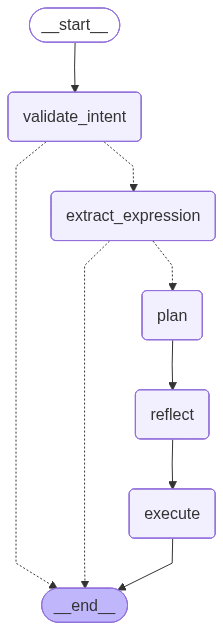

In [23]:
try:    
    # Get the graph visualization
    graph_image = math_solver.get_graph().draw_mermaid_png()
    
    # Display it
    display(Image(graph_image))

except Exception as e:
    print(f"\nCould not display graph: {e}")

## Testing the System

Let's test our system architected with Plan-and-Execute pattern

### Test Case 1: Simple Expression

In [24]:
print("\n" + "-"*60)
print("TEST CASE 1: Simple Expression")
print("-"*60)

initial_state = {
    "messages": [HumanMessage(content="Calculate 3 + 5 * 2")],
    "intent_valid": False,
    "expression_valid": False,
    "expression_to_compute": "",
    "plan": "",
    "result": ""
}

result = math_solver.invoke(initial_state)
print("\n" + "="*60)
print("FINAL OUTPUT:")
print("="*60)
print(result["messages"][-1].content)


------------------------------------------------------------
TEST CASE 1: Simple Expression
------------------------------------------------------------

Intent Valid: True
['3', '+', '5', '*', '2']

Expression Extraction and Validation
Expression extracted: 3+5*2
Expression valid: {'valid': True, 'error': ''}

Planning Complete

Plan: Step 1: Multiply 5 by 2 using multiply(5, 2) → result1
Step 2: Add 3 and result1 using add(3, result1) → final_result



Reflection Complete

Validated / Corrected Plan:
Step 1: Multiply 5 by 2 using multiply(5, 2) → result1
Step 2: Add 3 and result1 using add(3, result1) → final_result


Execution starting:
  TOOL CALLED: multiply
   INPUT: a = 5.0, b = 2.0
   OUTPUT: {'status': 'success', 'result': 10.0}
  TOOL CALLED: add
   INPUT: a = 3.0, b = 10.0
   OUTPUT: {'status': 'success', 'result': 13.0}
   RESPONSE: PROCESS_DESCRIPTION: 
Step 1:
- Tool and operators: functions.multiply (multiply), operands 5 and 2.
- Execution: multiply(5, 2) → 10
- Stored

### Test Case 2: Complex Expression with Factorial and Power

In [25]:
print("\n\n" + "-"*60)
print("TEST CASE 2: Complex Expression")
print("-"*60)

initial_state = {
    "messages": [HumanMessage(content="Solve 2^3 + 4! - 10")],
    "intent_valid": False,
    "expression_valid": False,
    "expression_to_compute": "",
    "plan": "",
    "result": ""
}

result = math_solver.invoke(initial_state)
print("\n" + "="*60)
print("FINAL OUTPUT:")
print("="*60)
print(result["messages"][-1].content)



------------------------------------------------------------
TEST CASE 2: Complex Expression
------------------------------------------------------------

Intent Valid: True
['2^3', '+', '4!', '-', '10']

Expression Extraction and Validation
Expression extracted: 2^3+4!-10
Expression valid: {'valid': True, 'error': ''}

Planning Complete

Plan: Step 1: Calculate 4! using factorial(4) → result1
Step 2: Calculate 2^3 using power(2, 3) → result2
Step 3: Add result2 and result1 using add(result2, result1) → result3
Step 4: Subtract 10 from result3 using subtract(result3, 10) → final_result



Reflection Complete

Validated / Corrected Plan:
Step 1: Calculate 4! using factorial(4) → result1
Step 2: Calculate 2^3 using power(2, 3) → result2
Step 3: Add result2 and result1 using add(result2, result1) → result3
Step 4: Subtract 10 from result3 using subtract(result3, 10) → final_result


Execution starting:
  TOOL CALLED: factorial
   INPUT: n = 4
   OUTPUT: {'status': 'success', 'result': 2

### Test Case 3: Invalid Intent (Not a Math Query)

In [26]:
print("\n\n" + "-"*60)
print("TEST CASE 3: Invalid Intent")
print("-"*60)

initial_state = {
    "messages": [HumanMessage(content="Hello! How are you today?")],
    "intent_valid": False,
    "expression_valid": False,
    "expression_to_compute": "",
    "plan": "",
    "result": ""
}

result = math_solver.invoke(initial_state)
print("\n" + "="*60)
print("FINAL OUTPUT:")
print("="*60)
print(result["messages"][-1].content)



------------------------------------------------------------
TEST CASE 3: Invalid Intent
------------------------------------------------------------

Intent Valid: False
Reason: The user is greeting and making small talk ("How are you today?"), not asking to compute a mathematical expression.

FINAL OUTPUT:
The user is greeting and making small talk ("How are you today?"), not asking to compute a mathematical expression.


### Test Case 4: Invalid Expression Syntax

In [27]:
print("\n\n" + "-"*60)
print("TEST CASE 4: Invalid Expression")
print("-"*60)

initial_state = {
    "messages": [HumanMessage(content="Calculate 3 + + 5")],
    "intent_valid": False,
    "expression_valid": False,
    "expression_to_compute": "",
    "plan": "",
    "result": ""
}

result = math_solver.invoke(initial_state)
print("\n" + "="*60)
print("FINAL OUTPUT:")
print("="*60)
print(result["messages"][-1].content)



------------------------------------------------------------
TEST CASE 4: Invalid Expression
------------------------------------------------------------

Intent Valid: True
['3', '+', '', '+', '5']

Expression Extraction and Validation
Expression extracted: 3 + + 5
Expression valid: {'valid': False, 'error': 'Invalid token found near: '}

FINAL OUTPUT:
The expression you gave is not valid. Please check it


### Test Case 5: Natural language Expression Syntax

In [28]:
print("\n\n" + "-"*60)
print("TEST CASE 5: Natural language Expression")
print("-"*60)

initial_state = {
    "messages": [HumanMessage(content="Compute the factorial of 4 and sum it to 5 then subtract 3 multiplied to 6")],
    "intent_valid": False,
    "expression_valid": False,
    "expression_to_compute": "",
    "plan": "",
    "result": ""
}

result = math_solver.invoke(initial_state)
print("\n" + "="*60)
print("FINAL OUTPUT:")
print("="*60)
print(result["messages"][-1].content)



------------------------------------------------------------
TEST CASE 5: Natural language Expression
------------------------------------------------------------

Intent Valid: True
['4!', '+', '5', '-', '3', '*', '6']

Expression Extraction and Validation
Expression extracted: 4!+5-3*6
Expression valid: {'valid': True, 'error': ''}

Planning Complete

Plan: Step 1: Calculate 4! using factorial(4) → result1
Step 2: Multiply 3 by 6 using multiply(3, 6) → result2
Step 3: Add result1 and 5 using add(result1, 5) → result3
Step 4: Subtract result2 from result3 using subtract(result3, result2) → final_result



Reflection Complete

Validated / Corrected Plan:
Step 1: Calculate 4! using factorial(4) → result1
Step 2: Calculate 3*6 using multiply(3, 6) → result2
Step 3: Add result1 and 5 using add(result1, 5) → result3
Step 4: Subtract result2 from result3 using subtract(result3, result2) → final_result


Execution starting:
  TOOL CALLED: factorial
   INPUT: n = 4
   OUTPUT: {'status': 'su

## Conclusions

The Reflect pattern can be used in situations where a system may fail or is likely to fail during specific operations. For example, code generators can analyze compilation errors at the end of the process and then rewrite the code to resolve those errors.  

A possible development workflow could be the following:
1. Develop the system without using the Reflect pattern.
2. Use and test the system.
3. Improve the prompts.
4. Use and test the system again.
5. Iterate steps 3 and 4.
6. Introduce the Reflect pattern to address recurring issues.

This approach can ultimately improve the system’s overall performance.